In [ ]:
#pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
from  pyspark.sql.functions import regexp_replace,col,split,explode
from pyspark.sql.functions import col,isnan, when, count
url='https://drive.google.com/file/d/1it3VAYze6nChmaxPHF3QLJcvoZhMsemQ/view?usp=sharing'
artist="artists"

Download Dataset

In [ ]:
file_id=url.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id
dwn_spotify=pd.read_csv(dwn_url)

Save to local machine

In [ ]:
dwn_spotify.to_csv('spotify.csv')

MongoSpark_Connectivity

In [ ]:
spark = SparkSession.builder.master("local[2]").appName("MongoSparkConnector").config("spark.mongodb.input.uri","mongodb://localhost:27017/mydb.spotify").config("spark.mongodb.output.uri","mongodb://localhost:27017/mydb.spotify").config("spark.jars", "E:\\mongojars\\mongo-spark-connector_2.12-3.0.1.jar,E:\\mongojars\\bson-4.0.5.jar,E:\\mongojars\\mongodb-driver-core-4.0.5.jar,E:\\mongojars\\mongodb-driver-sync-4.0.5.jar").getOrCreate()

Cleaning the DataFrame

In [ ]:
#reading file from local machine using Spark
raw_data=spark.read.csv(path="spotify.csv",
                         header=True,
                         inferSchema=True,
                         )

In [ ]:
raw_data.head(2)

[Row(_c0=0, acousticness=0.991, artists="['Mamie Smith']", danceability='0.598', duration_ms='168333', energy='0.2239999999999999', explicit='0', id='0cS0A1fUEUd1EW3FcF8AEI', instrumentalness='0.000522', key='5', liveness='0.379', loudness='-12.628', mode='0', name='Keep A Song In Your Soul', popularity='12', release_date='1920', speechiness='0.0936', tempo='149.976', valence='0.634', year='1920'),
 Row(_c0=1, acousticness=0.643, artists='"[""Screamin\' Jay Hawkins""]"', danceability='0.852', duration_ms='150200', energy='0.517', explicit='0', id='0hbkKFIJm7Z05H8Zl9w30f', instrumentalness='0.0264', key='5', liveness='0.0809', loudness='-7.261', mode='0', name='I Put A Spell On You', popularity='7', release_date='1920-01-05', speechiness='0.0534', tempo='86.889', valence='0.95', year='1920')]

In [ ]:
raw_data.count()

174389

In [ ]:
#spilts artist column
df_artist_split=raw_data.withColumn(artist,regexp_replace(artist,"[\\[\\]]","")).withColumn(artist,regexp_replace(artist,"'","")).withColumn(artist,regexp_replace(artist,"\"",""))

In [ ]:
df_data_casting = df_artist_split.select(df_artist_split.acousticness.cast("float"),df_artist_split.artists.cast("string"),df_artist_split.danceability.cast("float"),df_artist_split.duration_ms.cast("int"),df_artist_split.energy.cast("float"),df_artist_split.explicit.cast("int"),df_artist_split.id.cast("string"),df_artist_split.instrumentalness.cast("float"),df_artist_split.key.cast("int"),df_artist_split.liveness.cast("float"),df_artist_split.loudness.cast("float"),df_artist_split.mode.cast("int"),df_artist_split.name.cast("string"),df_artist_split.popularity.cast("int"),df_artist_split.release_date.cast("string"),df_artist_split.speechiness.cast("float"),df_artist_split.tempo.cast("float"),df_artist_split.valence.cast("float"),df_artist_split.year.cast("string"))

In [ ]:
df_data_casting.printSchema()

root
 |-- acousticness: float (nullable = true)
 |-- artists: string (nullable = true)
 |-- danceability: float (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- energy: float (nullable = true)
 |-- explicit: integer (nullable = true)
 |-- id: string (nullable = true)
 |-- instrumentalness: float (nullable = true)
 |-- key: integer (nullable = true)
 |-- liveness: float (nullable = true)
 |-- loudness: float (nullable = true)
 |-- mode: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- release_date: string (nullable = true)
 |-- speechiness: float (nullable = true)
 |-- tempo: float (nullable = true)
 |-- valence: float (nullable = true)
 |-- year: string (nullable = true)



In [ ]:
df_clean_data=df_data_casting.na.drop("any")

In [ ]:
df_clean_data.show(2)

+------------+--------------------+------------+-----------+------+--------+--------------------+----------------+---+--------+--------+----+--------------------+----------+------------+-----------+-------+-------+----+
|acousticness|             artists|danceability|duration_ms|energy|explicit|                  id|instrumentalness|key|liveness|loudness|mode|                name|popularity|release_date|speechiness|  tempo|valence|year|
+------------+--------------------+------------+-----------+------+--------+--------------------+----------------+---+--------+--------+----+--------------------+----------+------------+-----------+-------+-------+----+
|       0.991|         Mamie Smith|       0.598|     168333| 0.224|       0|0cS0A1fUEUd1EW3Fc...|         5.22E-4|  5|   0.379| -12.628|   0|Keep A Song In Yo...|        12|        1920|     0.0936|149.976|  0.634|1920|
|       0.643|Screamin Jay Hawkins|       0.852|     150200| 0.517|       0|0hbkKFIJm7Z05H8Zl...|          0.0264|  5|  

In [ ]:
# Show the distinct artist entries
df_clean_data.select('artists').distinct().show(40, truncate=False)

+---------------------------------------------------------+
|artists                                                  |
+---------------------------------------------------------+
|Mixalis Thomakos                                         |
|Kamala Jharia                                            |
|Anton Rubinstein, Oscar Levant                           |
|La Sonora Matancera                                      |
|Alvin & The Chipmunks, David Seville                     |
|The Partridge Family                                     |
|Rufus, Chaka Khan                                        |
|Ismael Rivera                                            |
|The Greg Kihn Band                                       |
|Generation X                                             |
|Afrika Bambaataa, The Soulsonic Force                    |
|Los Lobos                                                |
|Eurythmics                                               |
|Felix Mendelssohn, Péter Nagy          

In [ ]:
#clean_data=clean_data.drop("_c0")

In [ ]:
df_clean_data.count()

173008

In [ ]:
#Distinct all columns
final_data = df_clean_data.distinct()
final_data.count()

170855

In [ ]:
final_data.write.format("com.mongodb.spark.sql.DefaultSource").option("database","mydb").option("collection", "spotify").save()

Py4JJavaError: An error occurred while calling o121.save.
: java.lang.UnsupportedOperationException: MongoCollection already exists
	at com.mongodb.spark.sql.DefaultSource.createRelation(DefaultSource.scala:76)
	at org.apache.spark.sql.execution.datasources.SaveIntoDataSourceCommand.run(SaveIntoDataSourceCommand.scala:46)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult$lzycompute(commands.scala:70)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult(commands.scala:68)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.doExecute(commands.scala:90)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:175)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:213)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:210)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:171)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:122)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:121)
	at org.apache.spark.sql.DataFrameWriter.$anonfun$runCommand$1(DataFrameWriter.scala:963)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:100)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:160)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:87)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:764)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:963)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:415)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:399)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Unknown Source)


In [ ]:
raw_spotify_data = spark.read.format("mongo").load()

In [ ]:
spotify_data=raw_spotify_data.drop('_id')

In [ ]:
spotify_data.printSchema()

root
 |-- acousticness: double (nullable = true)
 |-- artists: string (nullable = true)
 |-- danceability: double (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- energy: double (nullable = true)
 |-- explicit: integer (nullable = true)
 |-- id: string (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- key: integer (nullable = true)
 |-- liveness: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- release_date: string (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- year: string (nullable = true)



# Machine Learning

In [ ]:
#pip install pymongo
import pymongo
import matplotlib.pyplot as plt, seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from tqdm import tqdm
sns.set()
from wordcloud import WordCloud,STOPWORDS
from sklearn.cluster import KMeans

In [ ]:
spotify_data.head()

Row(acousticness=0.9950000047683716, artists='Fortugé', danceability=0.5540000200271606, duration_ms=183840, energy=0.20399999618530273, explicit=0, id='4iy1fsAHBgR2STJjPDhjY2', instrumentalness=1.2399999604895129e-06, key=7, liveness=0.15299999713897705, loudness=-14.763999938964844, mode=1, name='Mes Parents Sont Venus Me Chercher', popularity=0, release_date='1922', speechiness=0.05979999899864197, tempo=97.33699798583984, valence=0.6200000047683716, year='1922')

Getting data from mongoClient

In [ ]:
client = pymongo.MongoClient('localhost', 27017)
db = client['mydb']
collection = db['spotify']

In [ ]:
spotify_data = pd.DataFrame(list(collection.find()))     

In [ ]:
final_spotify_data=spotify_data.drop('_id',axis=1)

In [ ]:
print('10 Most Popular Songs on Spotify from 1921 to 2021')
final_spotify_data[['name','artists','release_date','popularity']].sort_values(by='popularity',ascending=False)[:10]

10 Most Popular Songs on Spotify from 1921 to 2021


,name,artists,release_date,popularity
17167,drivers license,Olivia Rodrigo,2021-01-08,100
65051,Mood (feat. iann dior),"24kGoldn, iann dior",2020-07-24,96
115602,positions,Ariana Grande,2020-10-30,96
46232,DÁKITI,"Bad Bunny, Jhay Cortez",2020-10-30,95
131786,BICHOTA,KAROL G,2020-10-23,95
59063,LA NOCHE DE ANOCHE,"Bad Bunny, ROSALÍA",2020-11-27,94
36391,Therefore I Am,Billie Eilish,2020-11-12,94
111141,Whoopty,CJ,2020-08-20,94
72388,34+35,Ariana Grande,2020-10-30,94
102616,WITHOUT YOU,The Kid LAROI,2020-11-06,94


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'drivers license'),
  Text(1, 0, 'Mood (feat. iann dior)'),
  Text(2, 0, 'positions'),
  Text(3, 0, 'Therefore I Am'),
  Text(4, 0, 'Whoopty'),
  Text(5, 0, '34+35'),
  Text(6, 0, 'WITHOUT YOU'),
  Text(7, 0, 'LA NOCHE DE ANOCHE'),
  Text(8, 0, 'DÁKITI'),
  Text(9, 0, 'What You Know Bout Love')])

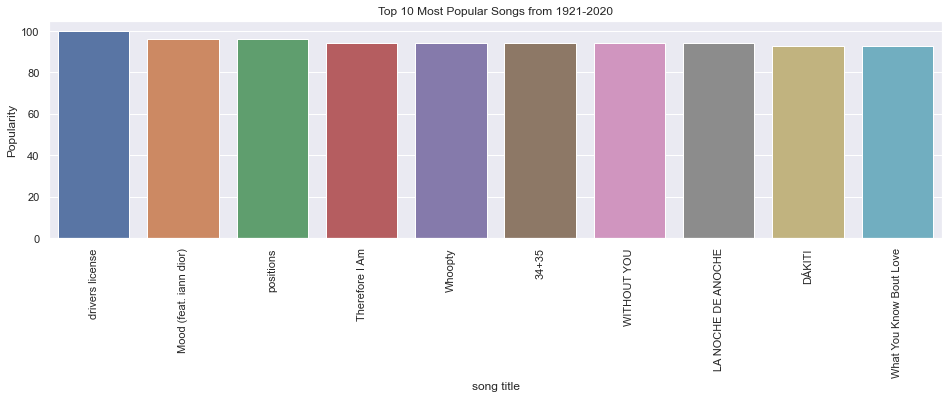

In [ ]:
plt.figure(figsize=(16, 4))
sns.set(style="darkgrid")

# group by the song's name and rank them base on their popularity
x = final_spotify_data.groupby("name")["popularity"].mean().sort_values(ascending=False).head(10)
axis = sns.barplot(x=x.index, y=x)
axis.set_title('Top 10 Most Popular Songs from 1921-2020')

axis.set_ylabel('Popularity')
axis.set_xlabel('song title')
plt.xticks(rotation = 90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'The Beatles'),
  Text(1, 0, 'Frank Sinatra'),
  Text(2, 0, 'Elvis Presley'),
  Text(3, 0, 'Fleetwood Mac'),
  Text(4, 0, 'The Rolling Stones'),
  Text(5, 0, 'Bob Dylan'),
  Text(6, 0, 'Led Zeppelin'),
  Text(7, 0, 'Taylor Swift'),
  Text(8, 0, 'Queen'),
  Text(9, 0, 'Johnny Cash'),
  Text(10, 0, 'The Beach Boys'),
  Text(11, 0, 'Bob Marley & The Wailers'),
  Text(12, 0, 'Pink Floyd'),
  Text(13, 0, 'David Bowie'),
  Text(14, 0, 'Vicente Fernández'),
  Text(15, 0, 'Elton John'),
  Text(16, 0, 'Miles Davis'),
  Text(17, 0, 'Ella Fitzgerald'),
  Text(18, 0, 'Dean Martin'),
  Text(19, 0, 'Metallica')])

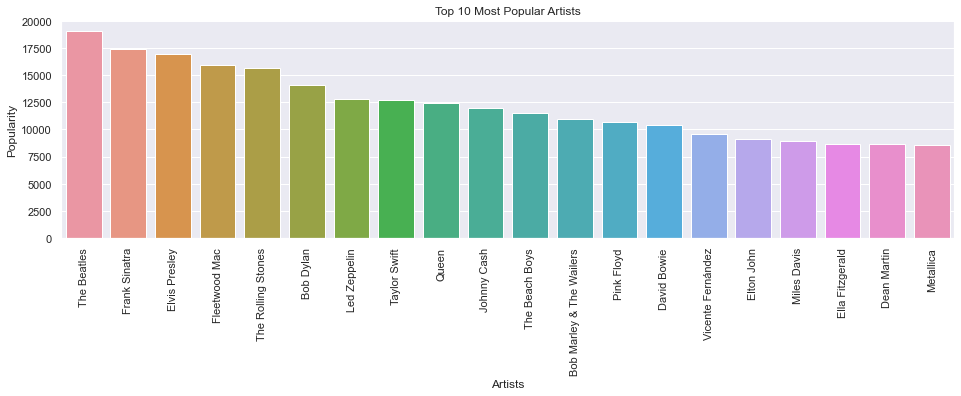

In [ ]:
#Most Popular artist on Spotify:
plt.figure(figsize=(16, 4))
sns.set(style="darkgrid")

# group by the song's name and rank them base on their popularity
x = final_spotify_data.groupby("artists")["popularity"].sum().sort_values(ascending=False).head(20)
axis = sns.barplot(x=x.index, y=x)
axis.set_title('Top 10 Most Popular Artists')

axis.set_ylabel('Popularity')
axis.set_xlabel('Artists')
plt.xticks(rotation = 90)

In [ ]:
#Unique Artists present in dataset
unique_artists = final_spotify_data['artists'].unique()
unique_artists

array(['Fortugé', 'Harry Curtis', 'Duke Ellington', ...,
       'Daniel Kandi, Martijn Stegerhoek', 'Ronnie Dunn',
       'XiJaro & Pitch'], dtype=object)

In [ ]:
len(unique_artists)

35485

In [ ]:
#count of artist has sang the most number of songs between 1921-2020:
song_counts=final_spotify_data.artists.value_counts()[:10]
song_counts

Tadeusz Dolega Mostowicz    1281
Эрнест Хемингуэй            1175
Эрих Мария Ремарк           1062
Francisco Canaro             951
Ignacio Corsini              624
Frank Sinatra                621
Elvis Presley                494
Bob Dylan                    459
Francisco Canaro, Charlo     456
Johnny Cash                  456
Name: artists, dtype: int64

In [ ]:
#Artist who  has the highest total duration of songs:
x=pd.DataFrame(final_spotify_data.groupby('artists')['duration_ms'].sum())
x.sort_values('duration_ms').tail().reset_index()

,artists,duration_ms
0,Эрнест Хемингуэй,136752454
1,Francisco Canaro,166146001
2,Miles Davis,167317072
3,Tadeusz Dolega Mostowicz,170037620
4,Umm Kulthum,219823306


In [ ]:
#Most successful year based on popularity rating
gr_yr = final_spotify_data.groupby('year')['popularity'].sum().sort_values()
print(gr_yr)

year
1922       11
1921       61
1924      156
1920      213
1931      214
        ...  
1997    90032
1998    90726
1999    93168
2002    93248
2020    99087
Name: popularity, Length: 102, dtype: int64


In [ ]:
# Remove Categorical Data ..
filter_data = final_spotify_data.drop(columns=['id', 'name', 'artists', 'release_date', 'year'])

In [ ]:
filter_data.corr()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence
acousticness,1.000000,-0.258037,-0.090229,-0.747990,-0.208934,0.229850,-0.026776,-0.031529,-0.542023,0.062895,-0.405375,-0.022311,-0.219831,-0.160340
danceability,-0.258037,1.000000,-0.101777,0.199774,0.200796,-0.221425,0.026076,-0.110408,0.244920,-0.046901,0.123686,0.240193,0.000277,0.536672
duration_ms,-0.090229,-0.101777,1.000000,0.061235,-0.034811,0.103438,0.001717,0.030954,0.020228,-0.047563,0.027217,-0.098276,-0.008403,-0.185186
energy,-0.747990,0.199774,0.061235,1.000000,0.101792,-0.183108,0.034480,0.136971,0.777591,-0.054280,0.336515,-0.114729,0.263185,0.321977
explicit,-0.208934,0.200796,-0.034811,0.101792,1.000000,-0.130200,0.005640,0.038166,0.105293,-0.063055,0.154621,0.354927,0.007123,-0.012512
instrumentalness,0.229850,-0.221425,0.103438,-0.183108,-0.130200,1.000000,-0.004924,-0.045657,-0.322162,-0.055750,-0.301033,-0.133849,-0.070689,-0.217549
key,-0.026776,0.026076,0.001717,0.034480,0.005640,-0.004924,1.000000,-0.003603,0.023854,-0.127033,0.001411,0.009995,0.004726,0.024539
liveness,-0.031529,-0.110408,0.030954,0.136971,0.038166,-0.045657,-0.003603,1.000000,0.063380,0.001703,-0.080528,0.122746,0.009672,-0.006629
loudness,-0.542023,0.244920,0.020228,0.777591,0.105293,-0.322162,0.023854,0.063380,1.000000,-0.017792,0.343263,-0.217175,0.215221,0.297498
mode,0.062895,-0.046901,-0.047563,-0.054280,-0.063055,-0.055750,-0.127033,0.001703,-0.017792,1.000000,0.006117,-0.041164,0.003911,0.022368


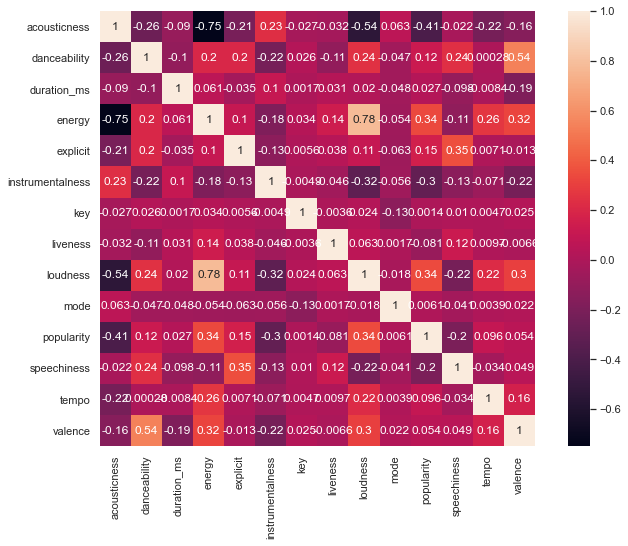

In [ ]:
# How are the attributes of the dataset are connected to each other
plt.subplots(figsize=(12, 8))
sns.heatmap(filter_data.corr(), annot=True, square=True)
plt.show()

In [ ]:
stop_words=set(STOPWORDS)
artists_string = " ".join(final_spotify_data['artists'])
wc = WordCloud(width=800,height=500,mask=None,random_state=21, max_font_size=110,stopwords=stop_words).generate(artists_string)

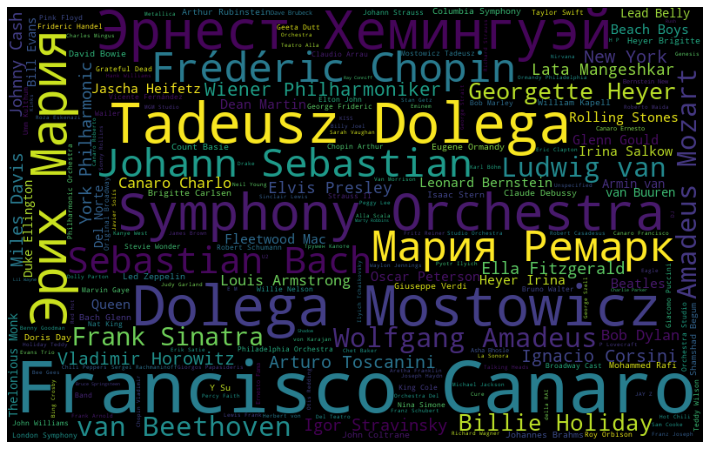

In [ ]:
fig=plt.figure(figsize=(16,8))
plt.axis('off')
plt.imshow(wc)

Normalization

In [ ]:
def normalize_column(col):
    """
    col - column in the dataframe which needs to be normalized
    """
    max_d =final_spotify_data[col].max()
    min_d = final_spotify_data[col].min()
    final_spotify_data[col] = (final_spotify_data[col] - min_d)/(max_d - min_d)
    
#Normalize allnumerical columns so that min value is 0 and max value is 1
num_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num = final_spotify_data.select_dtypes(include=num_types)
        
for col in num.columns:
    normalize_column(col)
    
#perform Kmeans CLustering
km = KMeans(n_clusters=35)
pred = km.fit_predict(num)
final_spotify_data['pred'] = pred
normalize_column('pred')

In [ ]:
final_spotify_data

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year,pred
0,0.998996,Fortugé,0.560729,0.033544,0.204,0.0,4iy1fsAHBgR2STJjPDhjY2,0.000001,0.636364,0.1530,0.708418,1.0,Mes Parents Sont Venus Me Chercher,0.00,1922,0.061586,0.399730,0.620,1922,0.000000
1,0.872490,Harry Curtis,0.494939,0.032836,0.392,0.0,6yqYqwtzaMNOHDiNScVuwc,0.000000,0.000000,0.0618,0.766596,1.0,Paper Doll,0.00,1923,0.034295,0.575281,0.552,1923,0.000000
2,0.978916,Duke Ellington,0.185223,0.032252,0.141,0.0,1bQ2BR5kCUrnvuTgfDwdiZ,0.833000,0.090909,0.1190,0.705019,1.0,Tonight I Shall Sleep,0.04,1925,0.037384,0.333153,0.160,1925,0.000000
3,0.930723,Test for Victor Young,0.742915,0.032017,0.474,0.0,6ivMXI6YMOPvsiUyTDIV7b,0.076200,0.909091,0.7370,0.774505,1.0,Bugle Call Rag,0.03,1925,0.263646,0.545315,0.902,1925,0.000000
4,0.998996,Francisco Canaro,0.638664,0.031417,0.222,0.0,3LFsQMhlxh56QnIfxy4SPO,0.970000,0.454545,0.2180,0.707337,0.0,Juguete de Placer - Remasterizado,0.00,1925-08-02,0.062719,0.474056,0.530,1925,0.911765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170850,0.402610,Florida Georgia Line,0.529352,0.035592,0.666,0.0,2tUJbvjNznjNZfCeKtkhGm,0.000000,0.636364,0.0726,0.875718,0.0,H.O.L.Y.,0.57,2016-08-26,0.033780,0.320627,0.562,2016,0.529412
170851,0.004819,"Hardage, Gil Scott-Heron, Enea DJ, Dj Lucas Wolf",0.659919,0.065872,0.918,0.0,4RrSb0bSX4z3DZQdVXSOSm,0.799000,0.545455,0.6570,0.825996,0.0,Hysterical Years - Enea DJ & Dj Lukas Wolf Remix,0.00,2017-07-10,0.146241,0.508967,0.564,2017,0.088235
170852,0.004016,Egyptian Meditation Temple,0.565790,0.059449,0.340,0.0,0XgFxbWd3awF18AD4GAgqN,0.930000,0.181818,0.1040,0.589789,0.0,Farewell to the Old Year,0.00,2019-02-26,0.037590,0.492766,0.854,2019,0.647059
170853,0.000031,XiJaro & Pitch,0.399798,0.042917,0.983,0.0,7zT90MghM92UVlqGN4exP2,0.846000,0.909091,0.1300,0.846073,1.0,Head Over Heels - Mixed,0.13,2020-12-25,0.065396,0.574020,0.078,2020,0.147059


In [ ]:
#Song Recommender
class Song_Recommender():
    """
    Neighbourhood Based Collborative Filterng REcoomendation System using similarity Metrics
    Manhattan Distance is calculated for all songs and Recommend Songs that are similar to it based on any given song
    """
    def __init__(self, data):
        self.data_ = data
    
    #function which returns recommendations, we can also choose the amount of songs to be recommended
    def get_recommendations(self, song_name, n_top):
        distances = []
        #choosing the given song_name and dropping it from the data
        song = self.data_[(self.data_.name.str.lower() == song_name.lower())].head(1).values[0]
        rem_data = self.data_[self.data_.name.str.lower() != song_name.lower()]
        for r_song in tqdm(rem_data.values):
            dist = 0
            for col in np.arange(len(rem_data.columns)):
                #indeces of non-numerical columns(id,Release date,name,artists,date)
                if not col in [1,6,12,14,18]:
                    #calculating the manhettan distances for each numerical feature
                    dist = dist + np.absolute(float(song[col]) - float(r_song[col]))
            distances.append(dist)
        rem_data['distance'] = distances
        #sorting our data to be ascending by 'distance' feature
        rem_data = rem_data.sort_values('distance')
        columns = ['artists', 'name','year']
        return rem_data[columns][:n_top]


#Instantiate recommender class
recommender = Song_Recommender(final_spotify_data)

#Get recommendations 'Red Roses (feat. Landon Cube)' song
recommender.get_recommendations('Red Roses (feat. Landon Cube)', 5)

100%|███████████████████████████████████████████████████████████████████████| 170854/170854 [00:06<00:00, 24887.31it/s]


,artists,name,year
24886,"Vince Staples, 6LACK, Mereba","""Yo Love - From """"Queen & Slim: The Soundtrack""""""",2019
70861,"Post Malone, Halsey, Future",Die For Me (feat. Future & Halsey),2019
63917,Ginuwine,In Those Jeans,2003
124827,Dirty Heads,Believe,2012
91914,"Baby Bash, Z-Ro, Berner, Baby E",Light Up Light Up,2014


In [ ]:
recommender.get_recommendations('stayin alive', 5)

100%|███████████████████████████████████████████████████████████████████████| 170853/170853 [00:05<00:00, 30585.95it/s]


,artists,name,year
85452,Bee Gees,"""Stayin' Alive - From """"Saturday Night Fever""""...",1979
38437,Aleks Syntek,Tú Necesitas,1999
28138,Kinto Sol,Ella Se Fue,2005
102684,Calo,Formas De Amor,1994
48362,Madonna,Holiday,2009
